# **Little Women GPT**


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

torch.manual_seed(1357)

# Data

In [2]:
with open('/kaggle/input/little-women/Little Women.txt','r',encoding='utf-8') as f:
    data = f.read()

# Character Level Tokenizer

In [3]:
class CharacterLevelTokenizer:
    def __init__(self,data):
        self.data = data
        self.vocab = sorted(list(set(self.data)))
        self.VOCAB_SIZE = len(self.vocab)
        
        self.i_s = {i:s for i,s in enumerate(self.vocab)}
        self.s_i = {s:i for i,s in self.i_s.items()}
        
    def encode(self,s):
        return torch.tensor([self.s_i[c] for c in s],dtype=torch.long)

    def decode(self,s):
        return ''.join([self.i_s[i.item()] for i in s])

tokenizer = CharacterLevelTokenizer(data)

# Config

In [4]:
@dataclass
class Config:
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    vocab_size = tokenizer.VOCAB_SIZE
    n_embed = 256
    n_heads = 8
    head_size = n_embed // n_heads # computes to 384/6=64 or 128/4=32 or 256/8
    
    n_layers = 3
    
    train_iters = 10_000
    val_iters = 1000
    lr = 3e-4
    
    attn_dropout = 0.1
    block_dropout = 0.1
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device

'cuda'

# Dataset

In [5]:
class LittleWomenDataset:
    def __init__(self,Config, is_test=False) -> None:
        self.tokenizer = CharacterLevelTokenizer(data)
        self.is_test = is_test
        self.full_data = self.tokenizer.encode(self.tokenizer.data)
        if self.is_test:
            self.data = self.full_data[int(0.9*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(0.9*len(self.full_data))]
        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.VOCAB_SIZE

    def get(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

---

# **GPT Model**

## Single Attention Head

In [6]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

In [8]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Transformer Block

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [10]:
class LittleWomenGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

# Training

In [11]:
train_ds = LittleWomenDataset(Config)
val_ds = LittleWomenDataset(Config,is_test=True)

In [12]:
lm = LittleWomenGPT(Config)
lm = lm.to(device=Config.device)

In [13]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

In [14]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

In [15]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = train_ds.get()
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"batch {batch} train step loss: {loss.item()}")
        
        del inputs, targets, loss, logits
        
    return train_step_losses
    
@torch.no_grad()
def valid_N_iters():
    lm.eval()
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = val_ds.get()
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        if batch%(Config.val_iters//10)==0 or batch==Config.val_iters-1:
            print(f"batch {batch} valid step loss: {loss.item()}")
        
        del inputs, targets, loss, logits
    
    return val_step_losses

In [16]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'littleWomenGPT'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'littleWomenGPT.pth'
    torch.save(state_dict, model_path)

In [17]:
def train_lm():
    train_losses = train_N_iters()
    valid_losses = valid_N_iters()
    save_lm()
    return train_losses, valid_losses

In [18]:
tl,vl=train_lm()

  0%|          | 0/10000 [00:00<?, ?it/s]

batch 0 train step loss: 4.8297576904296875
batch 1000 train step loss: 2.393845319747925
batch 2000 train step loss: 1.9735779762268066
batch 3000 train step loss: 1.8298275470733643
batch 4000 train step loss: 1.6991515159606934
batch 5000 train step loss: 1.6958110332489014
batch 6000 train step loss: 1.6151740550994873
batch 7000 train step loss: 1.6287517547607422
batch 8000 train step loss: 1.5887075662612915
batch 9000 train step loss: 1.589759111404419
batch 9999 train step loss: 1.534049391746521


  0%|          | 0/1000 [00:00<?, ?it/s]

batch 0 valid step loss: 1.8408539295196533
batch 100 valid step loss: 1.7896913290023804
batch 200 valid step loss: 1.7736196517944336
batch 300 valid step loss: 1.7602323293685913
batch 400 valid step loss: 1.823272466659546
batch 500 valid step loss: 1.7935885190963745
batch 600 valid step loss: 1.8540006875991821
batch 700 valid step loss: 1.8438501358032227
batch 800 valid step loss: 1.8564653396606445
batch 900 valid step loss: 1.8272274732589722
batch 999 valid step loss: 1.723017930984497


# Loss Plots

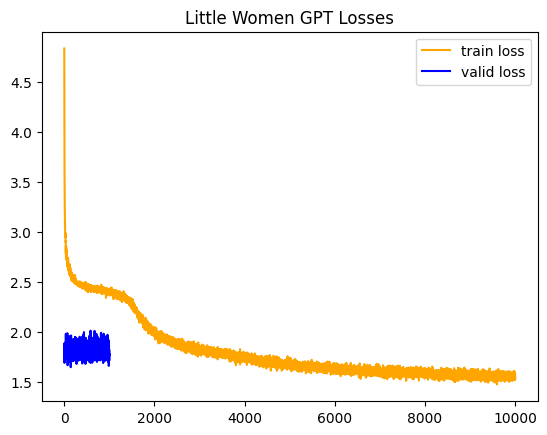

In [19]:
plt.plot(tl,label='train loss',color='orange')
plt.plot(vl,label='valid loss',color='blue')
plt.title('Little Women GPT Losses')
plt.legend()
plt.show()

# Generating

In [20]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device), # initial context 0
    total=length
)
    generated = tokenizer.decode(generated[0])
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)

sweet, for me one in I was people to jellowed a Mr. Kattons; down in
smoock, and mother, and it to p


generated (300 tokens)

it she prinks if Jo as unspair.
Laurie before his well-little for all of her, the felt his knows
wirdret she beep waiting to thought table an at sibly mindle tasked that her help
storish how that of the young, made say were recome howere without
before, Fath, and keeped Jo hurringly about a hucce-cu


generated (500 tokens)

every, no pricent girls I love to keep in one, after my myself.
Fold had no much, hone that Jo me a left and didn't you plactly.
"Ah! I'd do you," said, asking Laurie her has himself Mr.
"You go see?" cattented fling," and Laurie, and Laurie us adown listing
some inving a beto quiet.
"So if word, but day en empentain?"
"Mare's his our to keep it?" will, Jo-kecighter have
smile had head. The had and at had
natrannall tryink him.
XVIVIGETHY one of
STLII the just, and brashed reclung junturne
a gar


generated (700 toke

In [21]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)